# Team Members
# Ahm Hamza, Ali Ahmed, Nilsa Bermudez, Ursula Podosenin

# Overview

Instructions
Identify a large 2-node network dataset—you can start with a dataset in a repository.  
Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

What can you infer about each of the distinct groups?


We chose a Marvel datasets from Kaggle - https://www.kaggle.com/code/tolgakurtulus/interactive-network-analysis-of-marvel-universe
and https://www.kaggle.com/datasets/hamnakaleemds/marvel-universe-characters-dataset/data
and https://www.kaggle.com/datasets/nilsabermudez/marvel-universe-top-100

In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# === : Load the raw hero network data ===
file_path = "https://raw.githubusercontent.com/nilsabermudez/Data620/refs/heads/main/Week4/hero-network.csv"
df = pd.read_csv(file_path)

# === : Normalize character pairs so that (A, B) and (B, A) are treated the same ===
df[["hero1", "hero2"]] = df[["hero1", "hero2"]].apply(sorted, axis=1, result_type='expand')

# === : Group by each unique hero pair and count occurrences ===
# This count becomes the weight (number of co-appearances)
df_weighted = df.groupby(["hero1", "hero2"]).size().reset_index(name="weight")

# 
print(f"Weighted hero network created in memory with {len(df_weighted)} unique connections.")

# === Step 4: Create a graph using NetworkX directly from df_weighted ===
df_weighted.columns = ['source', 'target', 'weight']  # Rename columns for clarity

G = nx.Graph()
for _, row in df_weighted.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# === Step 5: Basic graph statistics ===
print(f"Total nodes (unique heroes): {G.number_of_nodes()}")
print(f"Total edges (unique hero pairs): {G.number_of_edges()}")

#df_weighted.head()

Weighted hero network created in memory with 167219 unique connections.
Total nodes (unique heroes): 6426
Total edges (unique hero pairs): 167219


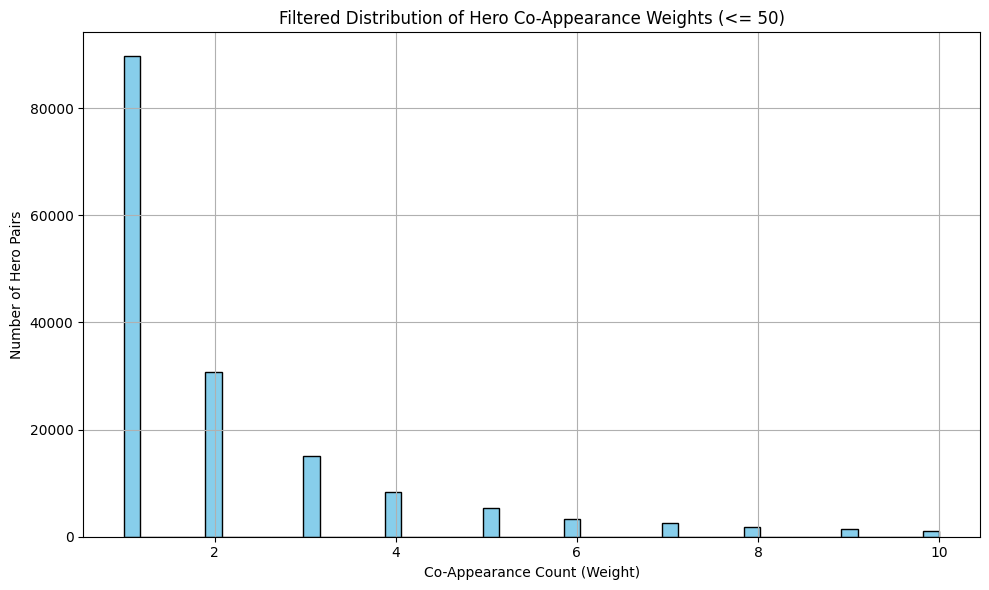

In [ ]:
# === : Visualize the distribution of edge weights ===
# This shows how frequently different hero pairs co-appeared
# Filter out extreme outliers for better visualization
filtered = df_weighted[df_weighted['weight'] <= 10]

# Plot histogram of edge weights (co-appearance counts)
plt.figure(figsize=(10, 6))
plt.hist(filtered['weight'], bins=50, color='skyblue', edgecolor='black')
plt.title("Filtered Distribution of Hero Co-Appearance Weights (<= 50)")
plt.xlabel("Co-Appearance Count (Weight)")
plt.ylabel("Number of Hero Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()

#df_weighted.head()
#df.head()


In [ ]:
# === : Build the full weighted graph from the filtered edge list ===
G = nx.Graph()
for _, row in df_weighted.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])
 


print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Total edges in full graph: {G.number_of_edges()}")

# === : Apply Island Method to filter strong connections ===
# Keep only edges with weight >= 3
threshold = 3
G_island = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= threshold)

print(f"Nodes in island graph (weight ≥ {threshold}): {G_island.number_of_nodes()}")
print(f"Edges in island graph (weight ≥ {threshold}): {G_island.number_of_edges()}")

# === Step 6: Remove isolated nodes (nodes with no remaining edges) ===
isolates = list(nx.isolates(G_island))
G_island.remove_nodes_from(isolates)

print(f"Nodes after removing isolates: {G_island.number_of_nodes()}")

Total nodes in full graph: 6426
Total edges in full graph: 167219
Nodes in island graph (weight ≥ 3): 3504
Edges in island graph (weight ≥ 3): 46867
Nodes after removing isolates: 3504


In [ ]:
# === : Load Node metadata (character group information) ===
nodes_path = "https://raw.githubusercontent.com/nilsabermudez/Data620/refs/heads/main/Week4/nodes.csv"

df_nodes = pd.read_csv(nodes_path)
df_nodes.columns = [col.lower() for col in df_nodes.columns]
node_groups = dict(zip(df_nodes['node'], df_nodes.get('type', ['Unknown'] * len(df_nodes))))


# Set node attributes for graph
nx.set_node_attributes(G_island, {node: {'group': node_groups.get(node, 'Unknown')} for node in G_island.nodes()})

In [ ]:
# === : Compute centrality measures on island graph ===
degree_centrality = nx.degree_centrality(G_island)
betweenness_centrality = nx.betweenness_centrality(G_island, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G_island, max_iter=1000, weight='weight')

# Create centrality dataframe 
centrality_df = pd.DataFrame({
    "character": list(G_island.nodes()),
    "degree_centrality": [degree_centrality[node] for node in G_island.nodes()],
    "betweenness_centrality": [betweenness_centrality[node] for node in G_island.nodes()],
    "eigenvector_centrality": [eigenvector_centrality[node] for node in G_island.nodes()]
})

In [ ]:
# === : Select Top 100 Most Connected Characters ===
top_100_df = centrality_df.sort_values(by='degree_centrality', ascending=False).head(100)
top_100_nodes = top_100_df['character'].tolist()

# === : Build subgraph of top 100 characters ===
G_top100 = G_island.subgraph(top_100_nodes).copy()

# === : Load group/type metadata and assign to top 100 graph ===
df_meta = pd.read_csv("https://raw.githubusercontent.com/nilsabermudez/Data620/refs/heads/main/Week4/character_classification.csv")
df_meta.columns = df_meta.columns.str.lower()  # 'character', 'group', 'type'

# Add attributes to G_top100
for _, row in df_meta.iterrows():
    char = row['character']
    if G_top100.has_node(char):
        G_top100.nodes[char]['group'] = row['group']
        G_top100.nodes[char]['type'] = row['type']

print("Example node with metadata:")
for n, d in list(G_top100.nodes(data=True))[:10]:
    print(n, d)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_top100, k=0.15, seed=42, weight='weight')

nx.draw_networkx_nodes(G_top100, pos, node_size=20, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_top100, pos, alpha=0.1)

plt.title(f"Marvel Island Graph (Nodes: {G_top100.number_of_nodes()}, Edges: {G_top100.number_of_edges()})")
plt.axis('off')
plt.show()

In [ ]:
# Extract node attributes and compute centralities
data = []
# Compute centralities only once
degree_centrality = nx.degree_centrality(G_top100)
betweenness_centrality = nx.betweenness_centrality(G_top100, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G_top100, weight='weight', max_iter=1000)

for node, attrs in G_top100.nodes(data=True):
    data.append({
        'character': node,
        'group': attrs.get('group', 'Unknown'),
        'degree': degree_centrality.get(node, 0),
        'betweenness': betweenness_centrality.get(node, 0),
        'eigenvector': eigenvector_centrality.get(node, 0)
    })

df = pd.DataFrame(data)

# Group by 'group' and calculate mean values
group_means = df.groupby('group')[['degree', 'betweenness', 'eigenvector']].mean().reset_index()

# Plotting average centralities by group
plt.figure(figsize=(14, 5))

# Degree Centrality
plt.subplot(1, 3, 1)
sns.barplot(data=group_means, x='group', y='degree')
plt.title("Average Degree Centrality by Group")  # x-axis: group, y-axis: mean degree
plt.xticks(rotation=45)

# Betweenness Centrality
plt.subplot(1, 3, 2)
sns.barplot(data=group_means, x='group', y='betweenness')
plt.title("Average Betweenness Centrality by Group")
plt.xticks(rotation=45)

# Eigenvector Centrality
plt.subplot(1, 3, 3)
sns.barplot(data=group_means, x='group', y='eigenvector')
plt.title("Average Eigenvector Centrality by Group")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

# Initialize counter for edge types
edge_type_counts = Counter()

# Iterate over all edges in G_top100
for u, v in G_top100.edges():
    type_u = G_top100.nodes[u].get('type', 'Unknown')
    type_v = G_top100.nodes[v].get('type', 'Unknown')

    # Normalize order for pairing (e.g., Hero–Villain same as Villain–Hero)
    edge_type = tuple(sorted([type_u, type_v]))
    edge_type_counts[edge_type] += 1

# Print results
print("Edge counts by type pair:")
for pair, count in edge_type_counts.items():
    print(f"{pair[0]} - {pair[1]}: {count}")

In [ ]:
# Convert to DataFrame for plotting
df_edge_types = pd.DataFrame({
    'pair': [f"{a}–{b}" for a, b in edge_type_counts.keys()],
    'count': list(edge_type_counts.values())
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_edge_types, x='pair', y='count')
plt.title("Edge Counts by Character Type Pair")
plt.ylabel("Number of Edges")
plt.xlabel("Type Pair")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define colors for groups
group_colors = {
    'Avengers': 'skyblue',
    'X-Men': 'gold',
    'Fantastic Four': 'lightgreen',
    'Guardians': 'violet',
    'Independent': 'gray',
    'Unknown': 'lightgray'
}

# Define marker shapes for character types
type_shapes = {
    'Hero': 'o',        # circle
    'Villain': '^',     # triangle
    'Anti-Hero': 's',   # square
    'Neutral': 'X',
    'Unknown': 'o'
}

# Create layout for consistent spacing
pos = nx.spring_layout(G_top100, seed=42, k=0.25, weight='weight')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(G_top100, pos, alpha=0.3)

# Draw nodes by type with color per group
for type_label, shape in type_shapes.items():
    nodes = [n for n, d in G_top100.nodes(data=True) if d.get('type') == type_label]
    node_colors = [group_colors.get(G_top100.nodes[n].get('group', 'Unknown'), 'lightgray') for n in nodes]
    
    nx.draw_networkx_nodes(
        G_top100, pos,
        nodelist=nodes,
        node_shape=shape,
        node_color=node_colors,
        node_size=300,
        label=type_label  # legend for type
    )

# Draw node labels optionally
# nx.draw_networkx_labels(G_top100, pos, font_size=8)

plt.title("Top 100 Character Network\n(Shape = Type, Color = Group)")
plt.axis('off')

# Create custom legends

# Legend for groups (colors)
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]

# Legend for types (shapes)
type_markers = {
    'Hero': 'o', 'Villain': '^', 'Anti-Hero': 's', 'Neutral': 'X', 'Unknown': 'o'
}
type_lines = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10, label=type_)
              for type_, marker in type_markers.items()]

# Show both legends
legend1 = plt.legend(handles=group_patches, title="Group", loc='lower left')
plt.gca().add_artist(legend1)
plt.legend(handles=type_lines, title="Type", loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize group-pair counter
group_edges = defaultdict(int)

# Count edges between groups
for u, v in G_top100.edges():
    group_u = G_top100.nodes[u].get('group', 'Unknown')
    group_v = G_top100.nodes[v].get('group', 'Unknown')

    # Sort to count symmetric interactions (A–B same as B–A)
    g1, g2 = sorted([group_u, group_v])
    group_edges[(g1, g2)] += 1

# Convert to square matrix (DataFrame)
unique_groups = sorted(set(group for pair in group_edges for group in pair))
matrix = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

for (g1, g2), count in group_edges.items():
    matrix.loc[g1, g2] = count
    matrix.loc[g2, g1] = count  # symmetric

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", square=True, cbar_kws={'label': 'Edge Count'})
plt.title("Interaction Matrix Between Groups")
plt.ylabel("Group 1")
plt.xlabel("Group 2")
plt.tight_layout()
plt.show()

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

# Apply greedy modularity-based community detection
communities = list(greedy_modularity_communities(G_top100))

# Assign each node to a community number
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Set as node attribute for visualization
nx.set_node_attributes(G_top100, community_map, name="community")

## We can infer from the above that:
Heroes mostly interact with other heroes. We see that by the tight-knit collaborations (teams like Avengers, X-Men).
We see Hero–Villain interactions are significantly fewer.
We see that villains rarely interact with each other, suggesting they are usually isolated threats or operate solo rather than in villainous teams.

When we look at the centrality scores, it's clear that heroes play a much more prominent role in the network. They have more direct connections (higher degree centrality), tend to be linked with other well-connected characters (higher eigenvector centrality), and often sit at key points in the network where information or interactions pass through them (higher betweenness). In contrast, villains usually appear on the edges of the network. They often connect to heroes but rarely to each other, reinforcing their roles as isolated adversaries rather than part of larger villain alliances.
